# 2024 SCOPED Workshop — Wavefield Simulations Using SPECFEM

## Notebook 5: Introduction to SeisFlows

- In this notebook we will introduce two open-source Python packages for facilitating/automating seismic imaging  
- **Objective**: To introduce and tour around SeisFlows and Pyatoa, and see how they can be used to simplify working with SPECFEM     
- These instructions should be run from inside a Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).  
-----------

**Relevant Links:** 
- This Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2024-05-10_scoped_uw/5_intro_seisflows.ipynb

**adjTomo Software Suite:** 
- adjTomo: https://github.com/adjtomo
- SeisFlows GitHub Page: https://github.com/adjtomo/seisflows
- SeisFlows Documentation: https://seisflows.readthedocs.io/en/latest/


**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.

----------
## 0) Background

- Full waveform inversion / adjoint tomography is an algorithmically and computationally complex procedure  
- For real-world regional scale inversion, the number of events and stations can range from tens to hundreds  
- For 3 component seismograms, this can reach tens of thousands of waveforms and misfit quantification calculations over the course of hundreds of simulations  
- Automated workflow tools cut down on human time and operator error when running repetitive and iterative inversions  
- They also free up research time to focus on details of an inversion, rather than implementation

![fwi_workflow](https://user-images.githubusercontent.com/23055374/194435095-8def121f-edc7-4408-be46-c0b84352ac6c.png)


### SeisFlows

- SeisFlows is one available tool for automating forward and adjoint simulations, as well as seismic inversions. 
- It comes with a built-in command line tool, and is written completely in Python  
- It provides `system` modules that allow it to interact with a variety of compute systems (laptops to HPC) using the same interface  
- SPECFEM2D and local capabilities allow quick prototyping and facilitate transition to 3D runs on clusters
- **BOTTOM LINE**: If you can successfully set up a forward problem yourself, then SeisFlows can take it from there and run the inverse problem.

### Pyatoa

- *Python's Adjoint Tomography Operations Assistant*: an ObsPy-like Python package used for misfit quantification  
- High-level wrapper for Pyflex, Pyadjoint, PyASDF, Pandas and ObsPy, all focused on the seismic imaging problem  
- Takes care of visualization and inversion assessment, implemented directly in the SeisFlows package but also operates as a standalone package 
- Motivated by tools and functionality I wish I had when performing a seismic inversion  

In [1]:
! seisflows -h

usage: seisflows [-h] [-w [WORKDIR]] [-p [PARAMETER_FILE]] [-v]
                 {init,configure,swap,submit,restart,clean,par,sempar,check,setup,plot2d,plotst,print,reset,debug,examples}
                 ...


                                SeisFlows v3.2.2                                


options:
  -h, --help            show this help message and exit
  -w [WORKDIR], --workdir [WORKDIR]
                        The SeisFlows working directory, default: cwd
  -p [PARAMETER_FILE], --parameter_file [PARAMETER_FILE]
                        Parameters file, default: 'parameters.yaml'
  -v, --version         Print out the current version of SeisFlows

command:
  Available SeisFlows arguments and their intended usages

    init                Runs SeisFlows first-time initiation procedures.
    configure           Fill parameter file with defaults
    swap                Swap module parameters in an existing parameter file
    submit              Submit initial workflow to system
    rest

---------
## 1) Automating the Forward Problem

- We'll first show how SeisFlows automates the forward problem  
- Users will need to supply starting model as well as real data or a target model  
- A single `parameters.yaml` file controls all of the SeisFlows workflow  

### 1a) Setting Up a SeisFlows Example Problem

- This setup procedure does exactly what we did in Day 1B, takes the Tape 2007 example problem and runs a forward simulation 
- This particular example uses the perturbation checkerboard model as the underlying model  
- See https://seisflows.readthedocs.io/en/devel/specfem2d_example.html for more examples
- See https://seisflows.readthedocs.io/en/devel/2D_example_walkthrough.html to figure out what's going on under the hood  

In [2]:
# Required Python packages for today's notebook
from pyasdf import ASDFDataSet
from pyatoa import Inspector
from IPython.display import Image

In [3]:
# Make sure we're in an empty working directory
! rm -r /home/scoped/work/intro_seisflows
! mkdir -p /home/scoped/work/intro_seisflows

%cd /home/scoped/work/intro_seisflows

# Setup Example 3, en-masse forward simulations. Don't run
! seisflows examples setup 3 -r  /home/scoped/specfem2d/ --with_mpi --nproc 1

rm: cannot remove '/home/scoped/work/intro_seisflows': No such file or directory
/home/scoped/work/intro_seisflows

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@@(       @@&    
                    

In [4]:
# Under the hood, the example SETUP procedure has run a forward simulation to generate our starting model  
! ls 
! echo
# Similar to the working directories we have been using during Days 1-3
! ls specfem2d_workdir
! echo
# OUTPUT_FILES contains model parameters
! ls specfem2d_workdir/OUTPUT_FILES_INIT
! echo
# 
! ls specfem2d_workdir/OUTPUT_FILES_INIT/*.bin

parameters.yaml  specfem2d_workdir

bin  DATA  OUTPUT_FILES  OUTPUT_FILES_INIT

AA.S0001.BXY.semd	    forward_image000004600.jpg
Database00000.bin	    forward_image000004800.jpg
forward_image000000005.jpg  forward_image000005000.jpg
forward_image000000200.jpg  mesh00000_rho.vtk
forward_image000000400.jpg  mesh00000_vp.vtk
forward_image000000600.jpg  mesh00000_vs.vtk
forward_image000000800.jpg  mesher.log.txt
forward_image000001000.jpg  mesh_materials.vtk
forward_image000001200.jpg  mesh_partition_number.vtk
forward_image000001400.jpg  output_list_stations.txt
forward_image000001600.jpg  plot_points_per_wavelength_histogram.gnu
forward_image000001800.jpg  plot_source_time_function.txt
forward_image000002000.jpg  points_per_wavelength_histogram_S_in_solid.txt
forward_image000002200.jpg  proc000000_data.bin
forward_image000002400.jpg  proc000000_jacobian.bin
forward_image000002600.jpg  proc000000_NSPEC_ibool.bin
forward_image000002800.jpg  proc000000_receivers_info.bin
forward_image000003

### 1b) The SeisFlows `parameters.yaml` file

- Similar to the SPECFEM `Par_file`, the SeisFlows `parameters.yaml` file controls the SeisFlows workflow
- Each 'module' of SeisFlows has a separate set of parameters
- The 'modules' of SeisFlows include: 
    - **Workflow:** the type of workflow and collection of tasks to run (e.g., forward, migration, inversion)  
    - **System:** controls interaction with the compute system (e.g., workstation, Slurm, Chinook)   
    - **Solver:** choose *which* external solver SeisFlows will interact with (i.e, specfem2d, 3d, 3d_globe (W.I.P.))
    - **Preprocess:** the preprocessing module to use for generating adjoint sources (i.e, default, Pyaflowa)
    - **Optimize:** the nonlinear optimization algorithm to use for model updates (e.g., gradient descent, L-BFGS)

In [5]:
# Looking at the available modules
! head -n 33 parameters.yaml

# //////////////////////////////////////////////////////////////////////////////
#
#                                SeisFlows v3.2.2                                
#
# //////////////////////////////////////////////////////////////////////////////
#
# SeisFlows YAML parameter file that determines code setup and runtime behavior.
# The following commands may be useful for manipulating this file.
#
#   * list out all available module choices:
#       > seisflows print modules
#   * configure the parameter file by autofilling module parameters:
#       > seisflows configure
#   * swap parameter sets between by choosing new modules:
#       > seisflows swap <module> <name> (e.g., seisflows swap solver specfem3d)
# 
# YAML syntax tips:
#   - NoneType == null
#   - infinity == inf
#
#                                    MODULES
#                                    ///////
# workflow (str):    The types and order of functions for running SeisFlows
# system (str):      Computer architecture of 

In [6]:
# Workflow: Forward parameters
! head -n 75 parameters.yaml | tail -n 42

# =============================================================================
#
#    Forward Workflow [Workflow Base]
#    --------------------------------
#    Defines foundational structure for Workflow module. When used standalone 
#    is in charge of running forward solver in parallel and (optionally) 
#    calculating data-synthetic misfit and adjoint sources.
#
#    Parameters
#    ----------
#    :type modules: list of module
#    :param modules: instantiated SeisFlows modules which should have been
#        generated by the function `seisflows.config.import_seisflows` with a
#        parameter file generated by seisflows.configure
#    :type generate_data: bool
#    :param generate_data: How to address 'data' in the workflow:
#        - False: real data needs to be provided by the User in
#        `path_data/{source_name}/*` in the same format that the solver will
#        produce synthetics (controlled by `solver.format`) OR
#        - True: 'data' will be generated as synt

In [7]:
# Solver: SPECFEM2D parameters
! head -n 213 parameters.yaml | tail -n 78

# =============================================================================
#
#    Solver SPECFEM [Solver Base]
#    ----------------------------
#    Defines foundational structure for Specfem-based solver module. 
#    Generalized SPECFEM interface to manipulate SPECFEM2D/3D/3D_GLOBE w/ Python
#
#    Parameters
#    ----------
#    :type syn_data_format: str
#    :param syn_data_format: data format for reading synthetic traces into memory.
#        Available: ['SU': seismic unix format, 'ASCII': human-readable ascii]
#    :type materials: str
#    :param materials: Material parameters used to define model. Available:
#        ['ELASTIC': Vp, Vs, 'ACOUSTIC': Vp, 'ISOTROPIC', 'ANISOTROPIC']
#    :type density: bool
#    :param density: How to treat density during inversion. If True, updates
#        density during inversion. If False, keeps it constant.
#        TODO allow density scaling during an inversion
#    :type attenuation: bool
#    :param attenuation: How to treat attenua

### 1c) Shared `DATA/` Directory

- SeisFlows borrows files from the SPECFEM *DATA/* directory but requires some special formatting  
- SeisFlows will look for `ntask` events with the prefix `source_prefix`
- Therefore, in this case all source files must be in the form `SOURCE_*`
- The suffix can be event names, ID numbers etc. They will be used to name and identify events during a workflow  


In [8]:
! seisflows par ntask
! seisflows par source_prefix
! echo
! ls specfem2d_workdir/DATA/SOURCE_*

ntask: 10
source_prefix: SOURCE

specfem2d_workdir/DATA/SOURCE_001  specfem2d_workdir/DATA/SOURCE_014
specfem2d_workdir/DATA/SOURCE_002  specfem2d_workdir/DATA/SOURCE_015
specfem2d_workdir/DATA/SOURCE_003  specfem2d_workdir/DATA/SOURCE_016
specfem2d_workdir/DATA/SOURCE_004  specfem2d_workdir/DATA/SOURCE_017
specfem2d_workdir/DATA/SOURCE_005  specfem2d_workdir/DATA/SOURCE_018
specfem2d_workdir/DATA/SOURCE_006  specfem2d_workdir/DATA/SOURCE_019
specfem2d_workdir/DATA/SOURCE_007  specfem2d_workdir/DATA/SOURCE_020
specfem2d_workdir/DATA/SOURCE_008  specfem2d_workdir/DATA/SOURCE_021
specfem2d_workdir/DATA/SOURCE_009  specfem2d_workdir/DATA/SOURCE_022
specfem2d_workdir/DATA/SOURCE_010  specfem2d_workdir/DATA/SOURCE_023
specfem2d_workdir/DATA/SOURCE_011  specfem2d_workdir/DATA/SOURCE_024
specfem2d_workdir/DATA/SOURCE_012  specfem2d_workdir/DATA/SOURCE_025
specfem2d_workdir/DATA/SOURCE_013


#### Required Paths

- SeisFlows needs to know the path to the *DATA/* directory to grab these files  
- SeisFlows also needs to know the path to the *bin/* directory so it can run SPECFEM executables  
- Finally, SeisFlows needs to know the path to your **model** files. The User is responsible for generating their mesh and model!  
- Additionally, SeisFlows maintains its own internal directory structure  

In [9]:
! tail -n 63 parameters.yaml

# =============================================================================
#
#	 Paths
#	 -----
#    :type workdir: str
#    :param workdir: working directory in which to perform a SeisFlows workflow.
#        SeisFlows internal directory structure will be created here. Default cwd
#    :type path_output: str
#    :param path_output: path to directory used for permanent storage on disk.
#        Results and exported scratch files are saved here.
#    :type path_data: str
#    :param path_data: path to any externally stored data required by the solver
#    :type path_state_file: str
#    :param path_state_file: path to a text file used to track the current
#        status of a workflow (i.e., what functions have already been completed),
#        used for checkpointing and resuming workflows
#    :type path_model_init: str
#    :param path_model_init: path to the starting model used to calculate the
#        initial misfit. Must match the expected `solver_io` format.
#    :type path_

### 1d) Swapping Modules

- SeisFlows can easily 'swap' modules from one to another  
- Used to facilitate the transition from a 2D, local, development environment, to a 3D HPC run  
- Replaces parameter set for **one** module only, leaving the others the same 

In [10]:
! seisflows print modules

                               SEISFLOWS MODULES                                
                               /////////////////                                
'-': module, '*': class

- workflow
    * forward
    * inversion
    * migration
    * noise_inversion
    * test_flow
- system
    * chinook
    * cluster
    * frontera
    * fujitsu
    * lsf
    * maui
    * singularity
    * slurm
    * wisteria
    * workstation
- solver
    * specfem
    * specfem2d
    * specfem3d
    * specfem3d_globe
- preprocess
    * default
    * pyaflowa
- optimize
    * LBFGS
    * NLCG
    * gradient


In [11]:
! seisflows par preprocess

preprocess: null


In [12]:
! seisflows swap preprocess default

created parameter file: parameters.yaml
configuring SeisFlows parameter file


In [13]:
! head -316 parameters.yaml | tail -n 103

# =============================================================================
#
#    Default Preprocess [Preprocess Base]
#    ------------------------------------
#    Data processing for seismic traces, with options for data misfit,
#    filtering, normalization and muting.
#
#    Parameters
#    ----------
#    :type obs_data_format: str
#    :param obs_data_format: data format for reading observed traces into
#        memory. Available formats: 'su', 'ascii', 'sac'
#    :type unit_output: str
#    :param unit_output: Data units. Must match the synthetic output of
#        external solver. Available: ['DISP': displacement, 'VEL': velocity,
#        'ACC': acceleration, 'PRE': pressure]
#    :type misfit: str
#    :param misfit: misfit function for waveform comparisons. For available
#        see seisflows.plugins.preprocess.misfit
#    :type adjoint: str
#    :param adjoint: adjoint source misfit function (backprojection function for
#        migration, or the objective function i

In [14]:
# Re-setting the preprocess module to None
! seisflows swap preprocess null

created parameter file: parameters.yaml
configuring SeisFlows parameter file


### 1e) Submit a Workflow

- Independent of your system, workflow etc., SeisFlows has only one entry point for running a workflow (`seisflows submit`)
- Under the hood, SeisFlows is doing what we manually did in the workshop, i.e., 
    - Generating working directories for each source
    - Checking acceptability of model parameters  
    - Setting the parameter file correctly for a forward simulation  
    - Running `xmeshfem2D` and `xspecfem2D` for each of the 10 sources  
 

In [15]:
! seisflows submit

2024-05-20 20:47:01 [WARN] | optional module 'preprocess' has not been instantiated, some functionality of the 'Forward' workflow may be skipped
2024-05-20 20:47:01 [INFO] | running setup for all modules
2024-05-20 20:47:01 [DEBU] | workflow.Forward
2024-05-20 20:47:07 [DEBU] | system.Workstation
2024-05-20 20:47:09 [DEBU] | solver.Specfem2D
2024-05-20 20:47:10 [INFO] | initializing 10 solver directories
2024-05-20 20:47:10 [DEBU] | source 0: 001
2024-05-20 20:47:10 [DEBU] | source 1: 002
2024-05-20 20:47:10 [DEBU] | source 2: 003
2024-05-20 20:47:10 [DEBU] | source 3: 004
2024-05-20 20:47:10 [DEBU] | source 4: 005
2024-05-20 20:47:10 [DEBU] | source 5: 006
2024-05-20 20:47:10 [DEBU] | source 6: 007
2024-05-20 20:47:10 [DEBU] | source 7: 008
2024-05-20 20:47:10 [DEBU] | source 8: 009
2024-05-20 20:47:15 [DEBU] | source 9: 010
2024-05-20 20:47:20 [DEBU] | linking source '001' as 'mainsolver'
2024-05-20 20:47:23 [INFO] | 
//////////////////////////////////////////////////////////////////

The workflow will be **complete** after it runs `xspecfem2D` for `source 010`

### 1f) Understanding a SeisFlows Working Directory

- Similar to SPECFEM, SeisFlows outputs log files, and output files  
- Most of the heavy lifting is done in the *scratch/* directory  
- Any files that should be saved permanently (seismograms, updated models during inversion) are storred in the *output/* directory  
- Any important log information (previously-used parameter files, error messages) are stored in the *logs/* directory  
- SeisFlows has an internal checkpointing routine, which takes advantage of the *sflog.txt* **state** file  
- See https://seisflows.readthedocs.io/en/devel/working_directory.html for more details

In [30]:
# All of the SeisFlows workflow is contained here
! ls

logs	parameters.yaml  sflog.txt    specfem2d_workdir
output	scratch		 sfstate.txt  waveforms


m_init_vs.png  MODEL_INIT  record_section.png  solver

proc000000_vp.bin  proc000000_vs.bin  proc000000_x.bin	proc000000_z.bin
Figure(707.107x707.107)


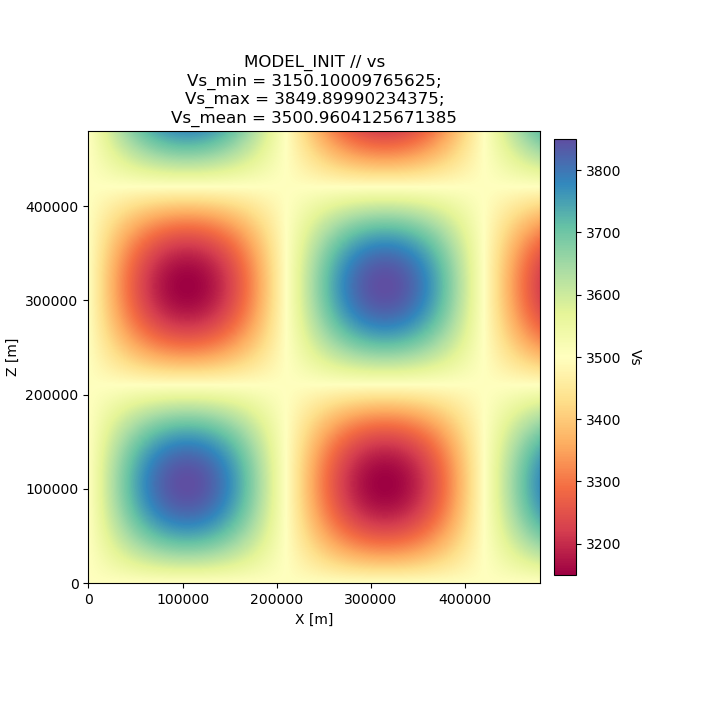

In [31]:
# Model files are stored in the output/ directory
! ls output
! echo
! ls output/MODEL_INIT

# We can use SeisFlows command line tools to plot the initial model
! seisflows plot2d MODEL_INIT vs --save output/m_init_vs.png
Image("output/m_init_vs.png")

In [32]:
# Synthetic seismograms output by the solvers are stored here as well
! ls output/solver
! echo
! ls output/solver/001
! echo
! ls output/solver/001/syn

001  002  003  004  005  006  007  008	009  010

syn

AA.S000000.BXY.semd  AA.S000009.BXY.semd  AA.S000018.BXY.semd
AA.S000001.BXY.semd  AA.S000010.BXY.semd  AA.S000019.BXY.semd
AA.S000002.BXY.semd  AA.S000011.BXY.semd  AA.S000020.BXY.semd
AA.S000003.BXY.semd  AA.S000012.BXY.semd  AA.S000021.BXY.semd
AA.S000004.BXY.semd  AA.S000013.BXY.semd  AA.S000022.BXY.semd
AA.S000005.BXY.semd  AA.S000014.BXY.semd  AA.S000023.BXY.semd
AA.S000006.BXY.semd  AA.S000015.BXY.semd  AA.S000024.BXY.semd
AA.S000007.BXY.semd  AA.S000016.BXY.semd
AA.S000008.BXY.semd  AA.S000017.BXY.semd


[2024-05-20 20:48:33] - pysep - INFO: starting record section plotter
[2024-05-20 20:48:33] - pysep - INFO: attempting to read 25 'syn' files from: output/solver/001/syn/
[2024-05-20 20:48:33] - pysep - INFO: no origin time set for SPECFEM2D source, setting dummy value: 1970-01-01T00:00:00
[2024-05-20 20:48:33] - pysep - INFO: reading origintime from event: 1970-01-01T00:00:00.000000Z
[2024-05-20 20:48:33] - pysep - DEBUG: output/solver/001/syn/AA.S000003.BXY.semd
[2024-05-20 20:48:33] - pysep - INFO: no origin time set for SPECFEM2D source, setting dummy value: 1970-01-01T00:00:00
[2024-05-20 20:48:33] - pysep - INFO: reading origintime from event: 1970-01-01T00:00:00.000000Z
[2024-05-20 20:48:33] - pysep - DEBUG: output/solver/001/syn/AA.S000002.BXY.semd
[2024-05-20 20:48:33] - pysep - INFO: no origin time set for SPECFEM2D source, setting dummy value: 1970-01-01T00:00:00
[2024-05-20 20:48:33] - pysep - INFO: reading origintime from event: 1970-01-01T00:00:00.000000Z
[2024-05-20 20:4

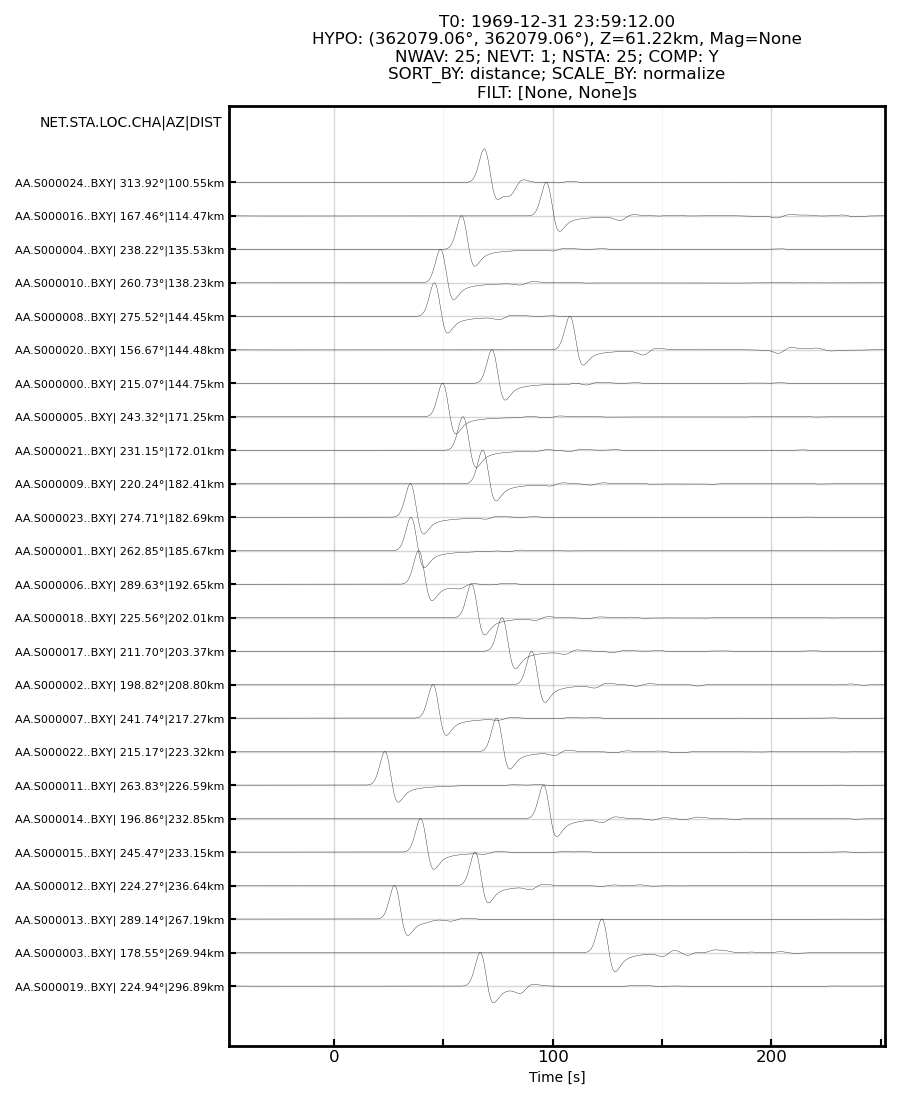

In [33]:
# We can use the RecSec to plot synthetics
! recsec --syn_path output/solver/001/syn/ --source specfem2d_workdir/DATA/SOURCE_001 --stations specfem2d_workdir/DATA/STATIONS --components Y --scale_by normalize --save output/record_section.png
Image("output/record_section.png")

### `scratch/` directory

- The active working directory of SeisFlows where all of the heavy lifting takes place  
- Each module in the SeisFlows package may have it’s own sub-directory where it stores temporary work data  
- Additionally, we have two eval*/ directories where objective function evaluation (eval_func) and gradient evaluation (eval_grad) files are stored  

In [34]:
! ls scratch

eval_grad  solver  system


In [35]:
! ls scratch/solver

001  002  003  004  005  006  007  008	009  010  mainsolver


In [36]:
# Each solver directory is simply a SPECFEM workding directory controlled by SeisFlows
# The main solver is used for tasks which are not mandatory for all events (e.g., smoothing)  
! ls scratch/solver/001

bin  DATA  fwd_mesher.log  fwd_solver.log  OUTPUT_FILES  traces


-----------
## 2) Exercise: Run an Inversion w/ SeisFlows

- Okay, now that we have solved the forward problem, we can tackle the inverse problem
- We will take our current working directory and make adjustments to the required modules to run an inversion
- First we'll clean up our working directory prior to getting started

In [23]:
# Move to the SeisFlows working directory
%cd /home/scoped/work/intro_seisflows
! ls 

/home/scoped/work/intro_seisflows
logs	parameters.yaml  sflog.txt    specfem2d_workdir
output	scratch		 sfstate.txt  waveforms


------------
In order to run our inversion, we will need a few components we did not have in the Forward problem, 
these tasks will help guide you into setting up your inversion. Much of the code you will need is available
in previous notebooks. 

### Task 1) Create 'Data'

#### Background
- To run an inversion, we need some kind of 'data' to compare to our synthetics, the data-synthetic differences (i.e., **misfit**) will guide the inversion.
- Often tomographers will run **synthetic inversions**, where are data consist of synthetic waveforms generated using a **target model**.
- In this example, we will take the data we just created in our forward simulations to use as our **target synthetics**.

#### Exercise Tasks
1) Identify `path_data` in the 'parameters.yaml' file, this is where SeisFlows expects waveform data  
   - You can open the file with the file manager, or use `seisflows par`
2) Create the required directory structure in `path_data`, which follows the format `{path_data}/{event_id}/`   
   - Each source requires its own sub-directory
   - Follow the source naming convention we covered earlier
3) Move or copy the synthetics generated by the forward problem we just ran into the directories you created in (2)  
   - Remember that synthetics are stored in: `scratch/solver/{event_id}/traces/syn/*`  
   - You can do this manually, with bash commands or with Python*)
4) Confirm that you have `ntask` sub-directories in `path_data`, each containing synthetic waveform data

In [24]:
# Space for Task 1

---------------
### Task 2) Generate a new 'Starting Model'

- Because our 'data' was generated using the checkerboard model shown above, we need a new 'starting model'
- If we do not change our starting model, the synthetics we generate will be the same as our **target synthetics**, resulting in 0 misfit
- Let's modify the model located in `specfem2d_workdir`, there are two approaches with (1) being easier than (2).  

#### Exercise Tasks

**Option 1 (Homogeneous Halfspace):**
1) Change the value of parameter `Model` in `specfem2d_workdir/DATA/Par_file` from `gll` -> `Default`
    - You can do this manually or use `seisflows sempar`
    - This will tell the internal mesher to use the parameter file definition of the model, which is a homogeneous halfspace
2) Rerun `xmeshfem2D` and `xspecfem2D` to generate the required Model files. You can find the syntax for running these commands in previous notebooks.
3) Reset `Model` parameter to `gll` for the inversion
   - We do this because the actual inversion uses this option to be able to update model parameters

**Option 2 (Checkerboard Perturbation):**
>Warning: This requires some Python skill
1) Change the value of parameter `Model` in `specfem2d_workdir/DATA/Par_file` from `gll` -> `legacy`
    - This will tell the internal mesher to read model values from the file `model_velocity.dat_input`
2) Find the file that defines the lgacy model values in `specfem2d_workdir/DATA` 
3) Modify this file in order to perturb the checkerboard model
    - The easiest thing to do is increase or decrease P and S-wave velocity structure by some percentage of their original value (5%?)
    - The column structure of this file is: `index, x-coordinate [m], y-coordinate [m], density, Vp [m/s], Vs [m/s]`
    - Probably best to use Python to read, write and modify the file (e.g., with NumPy `loadtxt` and `savetxt`)
5) Rerun `xmeshfem2D` and `xspecfem2D` to generate the required Model files. You can find these commands in previous notebooks.
6) Reset `Model` parameter to `gll` for the inversion
   - We do this because the actual inversion uses this option to be able to update model parameters


In [25]:
# Space for Task 2

----------------
### Task 3) Set up your SeisFlows Parameter File

- Now we need to modify our existing parameter file to switch our workflow from Forward simulations to Inversion
- Inversion workflows require additional modules for `preprocess` for data-synthetic comparisons, 
- They also require an `optimize` module which is in charge of model updates
- We will use the `seisflows swap` command which swaps in the set of parameters associated with a given module
- You can use the command `seisflows print modules` to check the available choices for each module

#### Exercise Tasks

1) `Swap` the `preprocess` module to option: `default`
    - SeisFlows currently has two preprocessing modules, 'Default' and 'Pyaflowa'
    - Both modules perform similar functionality, but Pyaflowa provides richer features such as windowing, improved data storage, and plotting
2) `Swap` the `optimize` module to option: `gradient`
    - The optimize module takes care of gradient regularization and model updates
    - Other optimization modules include L-BFGS and Nonlinear Conjugate Gradient (NLCG)
3) `Swap` the `workflow` module to option: `inversion`
    - The `inversion` submodule builds upon the forward simulation and adds in functionality for generating kernels and updating models
    - Other workflow modules include: Forward, Migration (for generating kernels), and NoiseInversion (for ambient noise adjoint tomography)
4) Change the location of `path_model_init` which points to your starting model.  
   - Note: in (2) we generated a starting model in `specfem2d_workdir/OUTPUT_FILES`
   - You might use the command `seisflows par` to change parameters from the command line, or do this manually

#### Optional Tasks
- Have a look through the remainder of the parameter file, are there parameters you think would be useful to change?
- You can run the Inversion as is, but advanced Users may play around with filtering (preprocess module) and smoothing (solver module) .

In [26]:
# Space for Task 3

--------------
### Task 4) Clean Up The Working Directory

- Run `seisflows clean` to delete all of the files from the previous Forward simulation, getting ready for our inversion.
- You can use the `-f/--force` option to skip over any 'are you sure about that?' prompts.

In [27]:
# Space for Task 4

-------------
### Task 5) Ready to Run? Check and See!

- When your data are ready, and your parameter file is setup, you can perform a sanity check 
- Run `seisflows check` to perform a number of internal checks that makes sure paths and parameters are set properly  
- If you receive any error messages from `seisflows check`, please fix them and re-run `seisflows check` to see if new errors pop up.

In [28]:
# Space for Task 5

### Task 6) Let's go!

If you think you're ready, run `seisflows submit` to start your inversion. 

In [29]:
# Space for Task 6